In [7]:
import os
import sys

sys.path.append("../../")

import getpass
import pickle
import uuid
from pathlib import Path

import geopandas as gpd
import pandas as pd
import shap
from shapely import wkt
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from povertymapping import nightlights, settings
from povertymapping.dhs import generate_dhs_cluster_level_data
from povertymapping.feature_engineering import generate_features
from povertymapping.iso3 import get_region_name

# Train model: Cross-country 
This notebook is for re-producing the final model used to estimate wealth for the countries with no DHS ground truth.

We combine data from 4 countries where we have DHS ground truth (KH, MM, PH, TL) and train one combined model from all these data. 
The features and wealth indices are scaled per country to make them comparable. 

The output model is a Random Forest regressor trained on scaled labels (DHS Wealth Index) and features (area statistics for OSM, Ookla, and nighttime lights).

We evaluated the performance of the model via a leave-one-out cross-validation procedure in a separate notebook. Refer to our [doc site](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/) for more details.


In [3]:
%reload_ext autoreload
%autoreload 2

## Set up Data Access for EOG (Nighttime lights)
The following cell will prompt you to enter your EOG username and password. See [this page](https://eogdata.mines.edu/products/register/) to learn how to set-up your EOG account.

In [4]:
# Log-in using EOG credentials
try:
    # This will attempt to get a cached version of the token first
    access_token = nightlights.get_eog_access_token("", "")
except Exception as e:
    username = os.environ.get("EOG_USER", None)
    username = username if username is not None else input("Username?")
    password = os.environ.get("EOG_PASSWORD", None)
    password = password if password is not None else getpass.getpass("Password?")
    access_token = nightlights.get_eog_access_token(username, password, save_token=True)

2023-04-12 11:49:22.487 | INFO     | povertymapping.nightlights:get_eog_access_token:48 - Saving access_token to ~/.eog_creds/eog_access_token
2023-04-12 11:49:22.490 | INFO     | povertymapping.nightlights:get_eog_access_token:56 - Adding access token to environmentt var EOG_ACCESS_TOKEN


## Generate training data from the combined 4 countries' data

We normalized each model feature by country to correct country-specific feature quirks, as well as the wealth index.

This method has been done in a [similar study](https://doi.org/10.1073/pnas.2113658119) using DHS as training data and was also documented [here](https://www.dhsprogram.com/pubs/pdf/MR9/MR9.pdf).

Models recover how relative values of input data (relative to other locations in that country) correlate with relative values of wealth (also relative to other locations in that country).

The current best model setup involves (1) normalizing all features per country using `StandardScaler` and (2) scaling the wealth index per country using `StandardScaler`

If this is your first time running this notebook for this specific area, expect a long runtime for the following cell as it will download and cache the required datasets. It will then process the relevant features for each area specified. On subsequent runs, the runtime will be much faster as the data is already stored in your filesystem. 


### Data config per country

In [5]:
# Set country-specific variables
country_config = {
    "Philippines": {
        "country_osm": "philippines",
        "ookla_year": 2019,
        "nightlights_year": 2017,
        "country_code": "ph",
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/ph/PHHR71DT/PHHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/ph/PHGE71FL/PHGE71FL.shp",
    },
    "Timor Leste": {
        "country_osm": "east-timor",
        "ookla_year": 2019,
        "nightlights_year": 2016,
        "country_code": "tl",
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/tl/TLHR71DT/TLHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/tl/TLGE71FL/TLGE71FL.shp",
    },
    "Cambodia": {
        "country_osm": "cambodia",
        "ookla_year": 2019,
        "nightlights_year": 2014,
        "country_code": "kh",
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/kh/KHHR73DT/KHHR73FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/kh/KHGE71FL/KHGE71FL.shp",
    },
    "Myanmar": {
        "country_osm": "myanmar",
        "ookla_year": 2019,
        "nightlights_year": 2015,
        "country_code": "mm",
        "dhs_household_dta_path": settings.DATA_DIR / "dhs/mm/MMHR71DT/MMHR71FL.DTA",
        "dhs_geographic_shp_path": settings.DATA_DIR / "dhs/mm/MMGE71FL/MMGE71FL.shp",
    },
}

rollout_date = "-".join(os.getcwd().split("/")[-1].split("-")[:3])

### Generate scaled features and labels per country

In [8]:
%%time

# Create list of dataframes per country, and list of all columns appearing in DHS columns
country_data_list = []

for country, config in country_config.items():
    print(f"Loading data for {country}")

    # Load the DHS cluster data
    dhs_gdf = generate_dhs_cluster_level_data(
        config["dhs_household_dta_path"],
        config["dhs_geographic_shp_path"],
        col_rename_config=config["country_code"],
        convert_geoms_to_bbox=True,
        bbox_size_km=2.4,
    ).reset_index(drop=True)

    # Create labels array by scaling the specified label_col (ex. Wealth Index)
    # Need to extract this before generating features because we'll be dropping the non-feature columns
    labels = MinMaxScaler().fit_transform(dhs_gdf[["Wealth Index"]])

    # Generate features
    features = generate_features(
        dhs_gdf,
        config["country_osm"],
        config["ookla_year"],
        config["nightlights_year"],
        sklearn_scaler=MinMaxScaler,
        scaled_only=True,
        features_only=True,
    )

    # Create combined GDF containing features and the label
    country_data = features.copy()
    country_data["label"] = labels

    country_data_list.append(country_data)

# Combine all country data into a single dataframe
countries_data = gpd.GeoDataFrame(
    pd.concat(country_data_list, ignore_index=True), crs=country_data_list[0].crs
)


# Split the GDF back into features and labels for training
feature_cols = [col for col in countries_data.columns if col != "label"]
features = countries_data[feature_cols]
labels = countries_data["label"]

Loading data for Philippines


2023-04-12 11:53:29.480 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-04-12 11:53:29.481 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_pois_free_1.shp
2023-04-12 11:53:35.496 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for philippines at /home/alron/.geowrangler/osm/philippines? True
2023-04-12 11:53:35.496 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for philippines being loaded from /home/alron/.geowrangler/osm/philippines/gis_osm_roads_free_1.shp
2023-04-12 11:54:22.864 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-12 11:54:22.864 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/34fe4b

Loading data for Timor Leste


2023-04-12 11:54:35.232 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-04-12 11:54:35.232 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_pois_free_1.shp
2023-04-12 11:54:36.606 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for east-timor at /home/alron/.geowrangler/osm/east-timor? True
2023-04-12 11:54:36.606 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for east-timor being loaded from /home/alron/.geowrangler/osm/east-timor/gis_osm_roads_free_1.shp
2023-04-12 11:54:37.134 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-12 11:54:37.135 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/0006e572a43b79

Loading data for Cambodia


2023-04-12 11:54:41.973 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-04-12 11:54:41.973 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_pois_free_1.shp
2023-04-12 11:54:43.817 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for cambodia at /home/alron/.geowrangler/osm/cambodia? True
2023-04-12 11:54:43.818 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for cambodia being loaded from /home/alron/.geowrangler/osm/cambodia/gis_osm_roads_free_1.shp
2023-04-12 11:54:49.058 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-12 11:54:49.059 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/6bc4328716bb3ab458a001835ee120

Loading data for Myanmar


2023-04-12 11:54:55.398 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-12 11:54:55.399 | DEBUG    | povertymapping.osm:load_pois:161 - OSM POIs for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_pois_free_1.shp
2023-04-12 11:54:57.851 | INFO     | povertymapping.osm:download_osm_country_data:199 - OSM Data: Cached data available for myanmar at /home/alron/.geowrangler/osm/myanmar? True
2023-04-12 11:54:57.852 | DEBUG    | povertymapping.osm:load_roads:180 - OSM Roads for myanmar being loaded from /home/alron/.geowrangler/osm/myanmar/gis_osm_roads_free_1.shp
2023-04-12 11:55:12.873 | DEBUG    | povertymapping.ookla:load_type_year_data:79 - Contents of data cache: []
2023-04-12 11:55:12.874 | INFO     | povertymapping.ookla:load_type_year_data:94 - Cached data available at /home/alron/.geowrangler/ookla/processed/2100117ec1967ae3e6d875971fb23fc6.csv? 

CPU times: user 1min 52s, sys: 2.12 s, total: 1min 54s
Wall time: 1min 54s


### Inspect the combined data

In [9]:
countries_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2720 entries, 0 to 2719
Data columns (total 62 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   poi_count_scaled                          2720 non-null   float64
 1   atm_count_scaled                          2720 non-null   float64
 2   atm_nearest_scaled                        2720 non-null   float64
 3   bank_count_scaled                         2720 non-null   float64
 4   bank_nearest_scaled                       2720 non-null   float64
 5   bus_station_count_scaled                  2720 non-null   float64
 6   bus_station_nearest_scaled                2720 non-null   float64
 7   cafe_count_scaled                         2720 non-null   float64
 8   cafe_nearest_scaled                       2720 non-null   float64
 9   charging_station_count_scaled             2720 non-null   float64
 10  charging_station_nearest_sca

In [10]:
countries_data.head()

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled,label
0,0.000000,0.0,1.000000,0.000000,0.224332,0.0,0.0,0.0,1.0,0.0,...,0.107772,0.008096,0.000651,0.001175,0.003882,0.000679,0.001337,0.000403,0.001404,0.374681
1,0.004112,0.0,1.000000,0.007752,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.160264,0.065863,0.015803,0.017085,0.004822,0.048494,0.018562,0.066474,0.004603,0.446489
2,0.000000,0.0,1.000000,0.000000,0.437469,0.0,0.0,0.0,1.0,0.0,...,0.376894,0.068733,0.005963,0.006994,0.003833,0.004762,0.002650,0.005322,0.001867,0.310939
3,0.000000,0.0,1.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.003259,0.000395,0.000889,0.000283,0.000839,0.317605
4,0.000000,0.0,0.873641,0.000000,0.876264,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.004039,0.000542,0.001235,0.000101,0.001166,0.253904


In [11]:
features.head()

,poi_count_scaled,atm_count_scaled,atm_nearest_scaled,bank_count_scaled,bank_nearest_scaled,bus_station_count_scaled,bus_station_nearest_scaled,cafe_count_scaled,cafe_nearest_scaled,charging_station_count_scaled,...,mobile_2019_mean_avg_d_kbps_mean_scaled,mobile_2019_mean_avg_u_kbps_mean_scaled,mobile_2019_mean_avg_lat_ms_mean_scaled,mobile_2019_mean_num_tests_mean_scaled,mobile_2019_mean_num_devices_mean_scaled,avg_rad_min_scaled,avg_rad_max_scaled,avg_rad_mean_scaled,avg_rad_std_scaled,avg_rad_median_scaled
0,0.000000,0.0,1.000000,0.000000,0.224332,0.0,0.0,0.0,1.0,0.0,...,0.052647,0.107772,0.008096,0.000651,0.001175,0.003882,0.000679,0.001337,0.000403,0.001404
1,0.004112,0.0,1.000000,0.007752,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.077665,0.160264,0.065863,0.015803,0.017085,0.004822,0.048494,0.018562,0.066474,0.004603
2,0.000000,0.0,1.000000,0.000000,0.437469,0.0,0.0,0.0,1.0,0.0,...,0.279220,0.376894,0.068733,0.005963,0.006994,0.003833,0.004762,0.002650,0.005322,0.001867
3,0.000000,0.0,1.000000,0.000000,1.000000,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.003259,0.000395,0.000889,0.000283,0.000839
4,0.000000,0.0,0.873641,0.000000,0.876264,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.004039,0.000542,0.001235,0.000101,0.001166


In [12]:
labels.head()

0    0.374681
1    0.446489
2    0.310939
3    0.317605
4    0.253904
Name: label, dtype: float64

<AxesSubplot: >

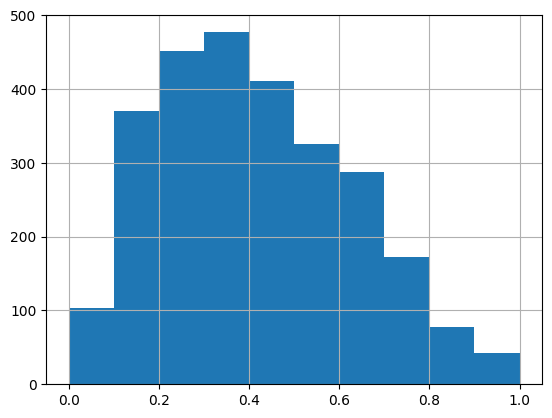

In [13]:
labels.hist()

## Model Training

We evaluated the performance of the model via a leave-one-out cross-validation procedure in a separate notebook. Refer to our [doc site](https://thinkingmachines.github.io/unicef-ai4d-poverty-mapping/) for more details.



In [14]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=0)
model

RandomForestRegressor(random_state=42)

In [15]:
model.fit(features.values, labels.values.ravel())

RandomForestRegressor(random_state=42)

### SHAP Feature Importance

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(features)

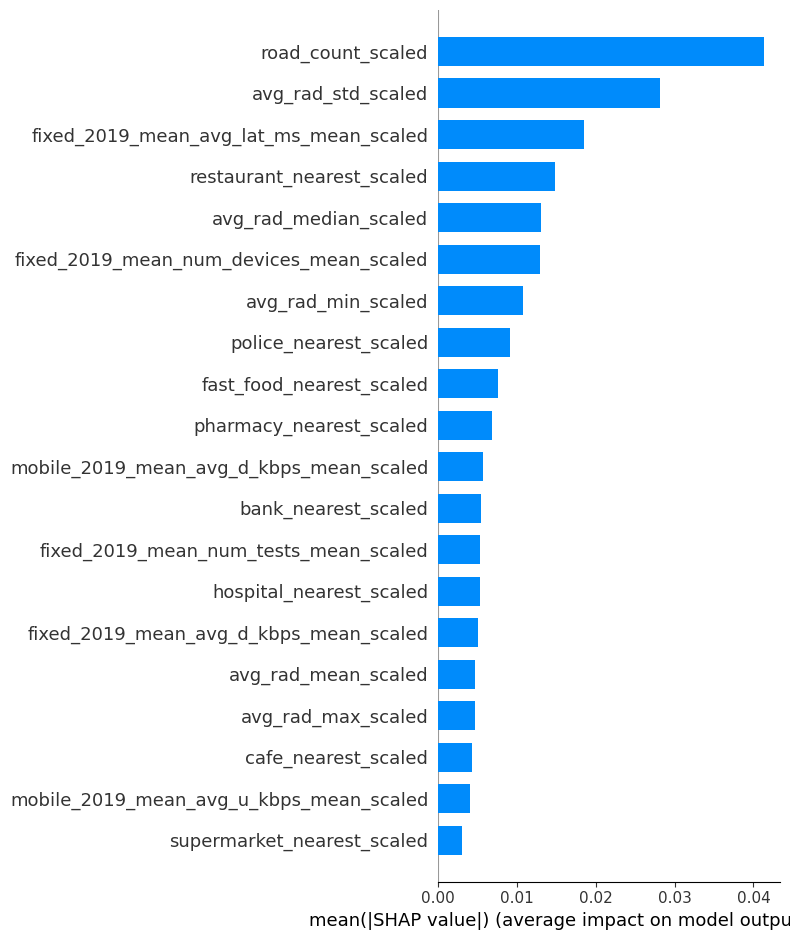

In [17]:
shap.summary_plot(
    shap_values, features, feature_names=features.columns, plot_type="bar"
)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


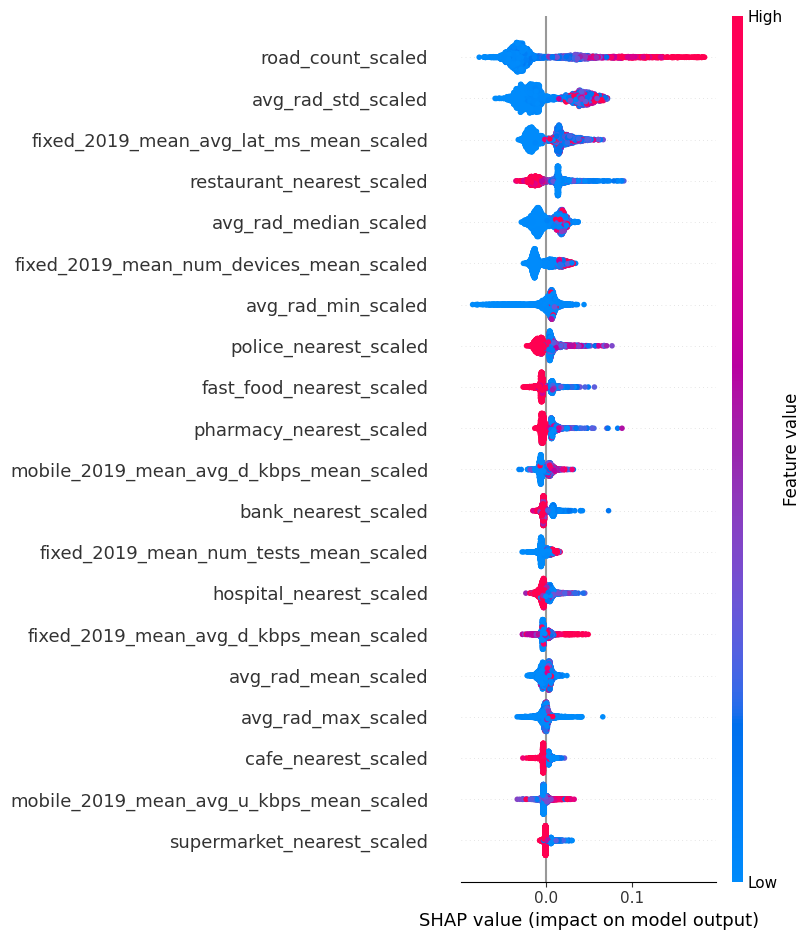

In [18]:
shap.summary_plot(shap_values, features.values, feature_names=features.columns)

## Save Model

In [19]:
model_save_path = f"./{rollout_date}-cross-country-model.pkl"
with open(model_save_path, "wb") as file:
    pickle.dump(model, file)